In [25]:
# Discrete Dosing Mechanistic PK-PD Model with Neural Parameter Estimation
# Complete rewrite with proper discrete dose handling

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchdiffeq import odeint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


In [26]:

# Set device and random seeds
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
np.random.seed(42)
print(f"Using device: {device}")


Using device: cpu


In [27]:

def torch_interp(x, xp, fp):
    """Simple linear interpolation for PyTorch tensors"""
    if len(xp) == 0:
        return torch.zeros_like(x)
    if len(xp) == 1:
        return fp[0].expand_as(x)
    
    indices = torch.searchsorted(xp, x, right=False)
    indices = torch.clamp(indices, 0, len(xp) - 1)
    indices_left = torch.clamp(indices - 1, 0, len(xp) - 1)
    indices_right = torch.clamp(indices, 0, len(xp) - 1)
    
    x_left = xp[indices_left]
    x_right = xp[indices_right] 
    y_left = fp[indices_left]
    y_right = fp[indices_right]
    
    dx = x_right - x_left
    dx = torch.where(dx == 0, torch.ones_like(dx), dx)
    
    weights = (x - x_left) / dx
    result = y_left + weights * (y_right - y_left)
    
    result = torch.where(x < xp[0], fp[0], result)
    result = torch.where(x > xp[-1], fp[-1], result)
    
    return result


In [28]:

# ============================================================================
# SECTION 1: DATA PREPARATION (unchanged from original)
# ============================================================================

class DataProcessor:
    """Handle all data loading, cleaning, and preparation tasks"""
    
    def __init__(self, data_path='Data\\EstData.csv'):
        self.data_path = data_path
        self.df = None
        self.pk_data = None
        self.pd_data = None
        self.dosing_data = None
        self.subject_info = None
        
    def load_and_examine_data(self):
        """Load data and perform initial examination"""
        
        print("="*80)
        print("SECTION 1: DATA PREPARATION - DISCRETE DOSING VERSION")
        print("="*80)
        
        # Load data
        print(f"Loading data from {self.data_path}...")
        self.df = pd.read_csv(self.data_path)
        
        # Basic data info
        print(f"\nData Overview:")
        print(f"  Total records: {len(self.df)}")
        print(f"  Subjects: {self.df['ID'].nunique()}")
        print(f"  Columns: {list(self.df.columns)}")
        
        # Separate data types
        self.pk_data = self.df[(self.df['DVID'] == 1) & (self.df['EVID'] == 0)].copy()
        self.pd_data = self.df[(self.df['DVID'] == 2) & (self.df['EVID'] == 0)].copy()
        self.dosing_data = self.df[self.df['EVID'] == 1].copy()
        
        print(f"\nData Breakdown:")
        print(f"  PK observations (DVID=1): {len(self.pk_data)}")
        print(f"  PD observations (DVID=2): {len(self.pd_data)}")
        print(f"  Dosing events (EVID=1): {len(self.dosing_data)}")
        
        return self
    
    def quality_checks(self):
        """Perform data quality assessment"""
        
        print("\nData Quality Checks:")
        
        # Check for missing values
        missing_counts = self.df.isnull().sum()
        if missing_counts.any():
            print("  Missing values found:")
            print(missing_counts[missing_counts > 0])
        else:
            print("  ✓ No missing values")
        
        # Check dose distribution
        dose_dist = self.df['DOSE'].value_counts().sort_index()
        print(f"  Dose distribution: {dose_dist.to_dict()}")
        
        # Check covariate ranges
        print(f"  Body weight range: {self.df['BW'].min():.1f} - {self.df['BW'].max():.1f} kg")
        print(f"  COMED distribution: {self.df['COMED'].value_counts().to_dict()}")
        
        # Check time ranges
        print(f"  Time range: {self.df['TIME'].min():.0f} - {self.df['TIME'].max():.0f} hours")
        
        return self
    
    def create_subject_summaries(self):
        """Create subject-level information"""
        
        print("\nCreating subject summaries...")
        
        subjects = []
        for subject_id in self.df['ID'].unique():
            subj_data = self.df[self.df['ID'] == subject_id]
            
            # Basic info
            bw = subj_data['BW'].iloc[0]
            comed = subj_data['COMED'].iloc[0]
            dose = subj_data['DOSE'].iloc[0]
            
            # PK data
            subj_pk = self.pk_data[self.pk_data['ID'] == subject_id]
            pk_observations = len(subj_pk)
            
            # PD data
            subj_pd = self.pd_data[self.pd_data['ID'] == subject_id]
            pd_observations = len(subj_pd)
            
            # Dosing data
            subj_dosing = self.dosing_data[self.dosing_data['ID'] == subject_id]
            n_doses = len(subj_dosing)
            
            subjects.append({
                'ID': subject_id,
                'BW': bw,
                'COMED': comed,
                'DOSE': dose,
                'PK_obs': pk_observations,
                'PD_obs': pd_observations,
                'N_doses': n_doses
            })
        
        self.subject_info = pd.DataFrame(subjects)
        
        print(f"  Subject summary created for {len(subjects)} subjects")
        print(f"  Dose group sizes: {self.subject_info.groupby('DOSE').size().to_dict()}")
        
        return self
    
    def train_validation_split(self, val_fraction=0.2):
        """Split subjects into training and validation sets"""
        
        print(f"\nSplitting data (validation fraction: {val_fraction})...")
        
        # Stratified split by dose group to ensure representation
        train_subjects, val_subjects = [], []
        
        for dose in self.subject_info['DOSE'].unique():
            dose_subjects = self.subject_info[self.subject_info['DOSE'] == dose]['ID'].values
            
            n_val = max(1, int(len(dose_subjects) * val_fraction))
            val_dose_subjects = np.random.choice(dose_subjects, n_val, replace=False)
            train_dose_subjects = [s for s in dose_subjects if s not in val_dose_subjects]
            
            train_subjects.extend(train_dose_subjects)
            val_subjects.extend(val_dose_subjects)
        
        self.train_subjects = train_subjects
        self.val_subjects = val_subjects
        
        print(f"  Training subjects: {len(train_subjects)}")
        print(f"  Validation subjects: {len(val_subjects)}")
        
        return self
    
    def get_subject_data(self, subject_id):
        """Get all data for a specific subject"""
        
        subj_info = self.subject_info[self.subject_info['ID'] == subject_id].iloc[0]
        
        return {
            'id': subject_id,
            'covariates': torch.tensor([subj_info['BW'], subj_info['COMED']], dtype=torch.float32),
            'dose': subj_info['DOSE'],
            'pk_data': self.pk_data[self.pk_data['ID'] == subject_id].copy(),
            'pd_data': self.pd_data[self.pd_data['ID'] == subject_id].copy(),
            'dosing_data': self.dosing_data[self.dosing_data['ID'] == subject_id].copy()
        }


In [ ]:

# ============================================================================
# SECTION 2: NEURAL NETWORK ARCHITECTURE (simplified for stability)
# ============================================================================
class DiscreteNeuralParameterEstimator(nn.Module):
    def __init__(self, n_subjects, embedding_dim=16):  # Keep signature for compatibility
        super().__init__()
        
        # Remove this line:
        # self.subject_embeddings = nn.Embedding(n_subjects, embedding_dim)
        
        # Keep population parameters unchanged
        self.pop_pk_params = nn.Parameter(torch.tensor([2.0, 6.0, 45.0, 8.0, 90.0]))
        self.pop_pd_params = nn.Parameter(torch.tensor([15.0, 1.5, 0.75, 5.0]))
        
        # Single layer MLP with reduced input
        input_dim = 3  # Only BW + COMED + dose_intensity
        # self.param_net = nn.Sequential(
        #     nn.Linear(input_dim, 9),
        #     nn.ReLU()
        # )
        # self.param_net = nn.Sequential(
        # nn.Linear(input_dim, 9),
        # nn.ReLU(),
        # nn.Dropout(0.1),
        # nn.Linear(9, 9),
        # nn.Sigmoid()  # Final activation
        # )
        self.param_net = nn.Sequential(
        nn.Linear(input_dim, 32),  # Increase from 9 to 32
        nn.ReLU(),
        nn.Dropout(0.2),
        # nn.Linear(32, 16),
        # nn.ReLU(),
        nn.Linear(16, 9),
        nn.Sigmoid()
        )
        # Define physiologically reasonable bounds
        self.pk_bounds = torch.tensor([
            [0.5, 5.0],    # Ka: 0.5-5.0 /h
            [2.0, 20.0],   # CL: 2-20 L/h
            [20.0, 100.0], # Vc: 20-100 L
            [2.0, 30.0],   # Q: 2-30 L/h
            [40.0, 200.0]  # Vp: 40-200 L
        ])
        
        self.pd_bounds = torch.tensor([
            [5.0, 25.0],   # Kin: 5-25 ng/mL/h
            [0.3, 3.0],    # Kout: 0.3-3.0 /h
            [0.3, 0.95],   # Imax: 30-95% max inhibition
            [1.0, 15.0]    # IC50: 1-15 ng/mL
        ])
        self._initialize_weights()
        
        print(f"Neural Network Architecture:")
        print(f"  Subjects: {n_subjects}")
        print(f"  Embedding dimension: {embedding_dim}")
        print(f"  Network: {input_dim}  → 9")
        print(f"  Total parameters: {sum(p.numel() for p in self.parameters())}")
        
    def _initialize_weights(self):
        """Initialize to directly target factor = 1.0"""
        
        for m in self.param_net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, gain=0.01)
                
                if m is self.param_net[-1]:  # Final layer
                    # Calculate bias to give factor = 1.0
                    # If factors = 0.1 + 1.9 * sigmoid(x), then for factor = 1.0:
                    # 1.0 = 0.1 + 1.9 * sigmoid(x)
                    # sigmoid(x) = 0.9/1.9 = 0.474
                    # x = logit(0.474) ≈ -0.105
                    nn.init.constant_(m.bias, -0.105)
                else:
                    nn.init.constant_(m.bias, 0.0)
        
    def forward(self, subject_ids, covariates, dose_intensities):
        """Forward pass with sigmoid-based multiplicative factors"""
        
        inputs = torch.cat([covariates, dose_intensities.unsqueeze(1)], dim=1)
        
        # Network outputs raw values (any real number)
        raw_outputs = self.param_net(inputs)
        
        # Apply sigmoid to map to [0, 1], then scale to factor range [0.5, 2.0]
        sigmoid_outputs = torch.sigmoid(raw_outputs)
        # factors = 0.5 + 1.5 * sigmoid_outputs  # Maps [0,1] to [0.5, 2.0]
        factors = 0.2 + 2.8 * sigmoid_outputs  # Maps to [0.2, 3.0]
        
        pk_factors = factors[:, :5]
        pd_factors = factors[:, 5:]
        
        # Apply multiplicative scaling to population parameters
        pk_params = self.pop_pk_params.unsqueeze(0) * pk_factors
        pd_params = self.pop_pd_params.unsqueeze(0) * pd_factors
        
        # Additional constraints for PD stability
        pd_params = torch.cat([
            pd_params[:, :1],  # Kin
            torch.clamp(pd_params[:, 1:2], min=0.3, max=2.5),  # Kout bounds
            torch.clamp(pd_params[:, 2:3], max=0.9),           # Imax < 1
            pd_params[:, 3:]   # IC50
        ], dim=1)
        
        return pk_params, pd_params
    
    def predict_single_subject(self, subject_id, bw, comed, dose_intensity):
        """Single subject prediction - subject_id no longer used"""
        
        # subject_id is ignored now
        covariates = torch.tensor([[bw, comed]], dtype=torch.float32)
        dose_intensities = torch.tensor([dose_intensity], dtype=torch.float32)
        
        was_training = self.training
        self.eval()
        
        # Pass dummy subject_ids for compatibility
        # dummy_subject_ids = torch.tensor([0])
        pk_params, pd_params = self.forward(subject_id, covariates, dose_intensities)
        
        self.train(was_training)
        return pk_params[0], pd_params[0]


In [40]:

# ============================================================================
# SECTION 3: DISCRETE DOSING MECHANISTIC MODEL
# ============================================================================

class DiscreteDosePKPDModel(nn.Module):
    """Mechanistic PK-PD model with discrete dosing - no rate spikes"""
    
    def __init__(self, param_estimator):
        super().__init__()
        
        print("="*80)
        print("SECTION 3: DISCRETE DOSING MECHANISTIC MODEL")
        print("="*80)
        
        self.param_estimator = param_estimator
        
        print("Mechanistic Model Components:")
        print("  PK Model: Two-compartment with first-order absorption")
        print("  PD Model: Indirect response (inhibition of production)")
        print("  Dosing: Discrete doses added directly to depot compartment")
        print("  NO continuous dose rates or numerical spikes")
        
    def ode_system_no_dosing(self, t, y, params):
        """ODE system without dosing - eliminates rate spikes completely"""
        
        A_depot, A_central, A_periph, R = y
        Ka, CL, Vc, Q, Vp, Kin, Kout, Imax, IC50 = params
        
        # PK equations (no dose input)
        dA_depot = -Ka * A_depot
        dA_central = Ka * A_depot - (CL/Vc) * A_central - (Q/Vc) * A_central + (Q/Vp) * A_periph
        dA_periph = (Q/Vc) * A_central - (Q/Vp) * A_periph
        
        # PD equation
        concentration = A_central / Vc
        inhibition = Imax * concentration / (IC50 + concentration + 1e-6)
        dR = Kin * (1 - inhibition) - Kout * R
        
        return torch.stack([dA_depot, dA_central, dA_periph, dR])
    
    # def simulate_subject_discrete(self, subject_id, covariates, dose_schedule, simulation_times):
    #     """Simulate with discrete dosing - stable and reliable"""
        
    #     # Get individual parameters
    #     total_dose = sum(dose_amt for _, dose_amt in dose_schedule)
    #     dose_intensity = total_dose / covariates[0]
        
    #     pk_params, pd_params = self.param_estimator.predict_single_subject(
    #         subject_id, covariates[0], covariates[1], dose_intensity)
        
    #     all_params = torch.cat([pk_params, pd_params])
        
    #     # Initial conditions
    #     baseline_biomarker = 16.0 * (1 + 0.1 * covariates[1])  # COMED effect
    #     y = torch.tensor([0.0, 0.0, 0.0, baseline_biomarker])
        
    #     # Create timeline with all important time points
    #     dose_times = [float(t) for t, _ in dose_schedule]
    #     sim_times_list = simulation_times.tolist()
    #     all_important_times = sorted(set([0.0] + dose_times + sim_times_list))
        
    #     # Solve in segments between dose times
    #     solutions = {}
    #     solutions[0.0] = y
        
    #     for i in range(len(all_important_times) - 1):
    #         t_start = all_important_times[i]
    #         t_end = all_important_times[i + 1]
            
    #         # Create time points for this segment
    #         segment_times = torch.tensor([t_start, t_end], dtype=torch.float32)
    #         y_start = solutions[t_start]
            
    #         # Solve ODE segment with no dosing
    #         try:
    #             segment_solution = odeint(
    #                 lambda t, state: self.ode_system_no_dosing(t, state, all_params),
    #                 y_start,
    #                 segment_times,
    #                 method='euler',
    #                 options={'step_size': 1.0},
    #                 rtol=1e-5,
    #                 atol=1e-6
    #             )
                
    #             y_end = segment_solution[-1]
                
    #             # Check for numerical issues
    #             if torch.isnan(y_end).any() or torch.isinf(y_end).any():
    #                 print(f"Warning: Numerical issue at t={t_end}")
    #                 # Use simple forward Euler as fallback
    #                 dt = t_end - t_start
    #                 dydt = self.ode_system_no_dosing(t_start, y_start, all_params)
    #                 y_end = y_start + dt * dydt
                
    #         except Exception as e:
    #             print(f"ODE solver failed, using Euler step: {e}")
    #             dt = t_end - t_start
    #             dydt = self.ode_system_no_dosing(t_start, y_start, all_params)
    #             y_end = y_start + dt * dydt
            
    #         solutions[t_end] = y_end
            
    #         # Add discrete dose if this is a dose time
    #         dose_amount = 0.0
    #         for dose_time, dose_amt in dose_schedule:
    #             if abs(t_end - dose_time) < 0.001:  # Floating point comparison
    #                 dose_amount += dose_amt
            
    #         if dose_amount > 0:
    #             solutions[t_end] = solutions[t_end].clone()  # Make it writable
    #             solutions[t_end][0] += dose_amount  # Add to depot compartment
        
    #     # Extract solutions at requested simulation times
    #     final_solution = torch.zeros(len(simulation_times), 4)
        
    #     for i, sim_time in enumerate(simulation_times):
    #         t = float(sim_time)
    #         if t in solutions:
    #             final_solution[i] = solutions[t]
    #         else:
    #             # Linear interpolation between nearest points
    #             t_before = max([time for time in solutions.keys() if time <= t])
    #             t_after = min([time for time in solutions.keys() if time >= t])
                
    #             if t_before == t_after:
    #                 final_solution[i] = solutions[t_before]
    #             else:
    #                 # Linear interpolation
    #                 alpha = (t - t_before) / (t_after - t_before)
    #                 final_solution[i] = (1 - alpha) * solutions[t_before] + alpha * solutions[t_after]
        
    #     return final_solution
    def simulate_subject_discrete(self, subject_id, covariates, dose_schedule, simulation_times, baseline_biomarker=16.0):
        """
        Simulate PK-PD response with discrete dosing using chronological integration
        
        Args:
            subject_id: Subject identifier for parameter prediction
            covariates: [body_weight, comed_status]
            dose_schedule: List of (time, dose_amount) tuples
            simulation_times: Times where output is needed
        """
        
        # Step 1: Get individual PK-PD parameters
        total_dose = sum(dose_amt for _, dose_amt in dose_schedule)
        dose_intensity = total_dose / covariates[0]  # We can discuss removing this later
        
        pk_params, pd_params = self.param_estimator.predict_single_subject(
            subject_id, covariates[0], covariates[1], dose_intensity)
        all_params = torch.cat([pk_params, pd_params])
        
        
        # Step 3: Initialize system state [depot, central, peripheral, biomarker]
        current_state = torch.tensor([0.0, 0.0, 0.0, baseline_biomarker])
        #                [depot_amount, central_amount, peripheral_amount, biomarker_concentration]
        #                [mg,           mg,             mg,                ng/mL]
        current_time = 0.0
        
        # Step 4: Create sorted event timeline
        dose_events = sorted(dose_schedule, key=lambda x: x[0])  # Sort by time
        max_time = max(simulation_times.max().item(), 
                    dose_events[-1][0] if dose_events else 0.0)
        
        # Step 5: Storage for solutions at all time points
        solution_dict = {0.0: current_state.clone()}
        
        # Step 6: Process each dosing interval chronologically
        for i, (dose_time, dose_amount) in enumerate(dose_events):
            
            # 6a: Integrate from current_time to dose_time (no dosing during integration)
            if dose_time > current_time:
                integration_times = torch.tensor([current_time, dose_time], dtype=torch.float32)
                
                try:
                    ode_solution = odeint(
                        lambda t, y: self.ode_system_no_dosing(t, y, all_params),
                        current_state,
                        integration_times,
                        # method='euler',
                        method = 'dopri5',
                        # options={'step_size': 1.0},
                        # method='dopri5',  # Changed to euler for stability
                        rtol=1e-4,
                        atol=1e-5
                    )
                    current_state = ode_solution[-1]  # State just before dose
                    
                except Exception as e:
                    print(f"ODE integration failed at t={dose_time}: {e}")
                    # Simple Euler fallback
                    dt = dose_time - current_time
                    dydt = self.ode_system_no_dosing(current_time, current_state, all_params)
                    current_state = current_state + dt * dydt
            
            # 6b: Store pre-dose state
            solution_dict[float(dose_time)] = current_state.clone()
            
            # 6c: Add discrete dose to depot compartment
            current_state[0] += dose_amount  # Instantaneous dose addition
            current_time = dose_time
            
            # 6d: Store post-dose state (same time, different state)
            solution_dict[float(dose_time) + 1e-6] = current_state.clone()
        
        # Step 7: Integrate from last dose to simulation end if needed
        if current_time < max_time:
            final_times = torch.tensor([current_time, max_time], dtype=torch.float32)
            
            try:
                final_solution = odeint(
                    lambda t, y: self.ode_system_no_dosing(t, y, all_params),
                    current_state,
                    final_times,
                    method='euler',
                    rtol=1e-3,
                    atol=1e-4
                )
                solution_dict[float(max_time)] = final_solution[-1]
                
            except Exception as e:
                print(f"Final integration failed: {e}")
                solution_dict[float(max_time)] = current_state
        
        # Step 8: Extract solutions at requested simulation_times via interpolation
        output_solution = torch.zeros(len(simulation_times), 4)
        
        # Get all available time points in order
        available_times = sorted(solution_dict.keys())
        
        for i, req_time in enumerate(simulation_times):
            t = float(req_time)
            
            if t in solution_dict:
                # Exact time point available
                output_solution[i] = solution_dict[t]
            else:
                # Linear interpolation between nearest points
                t_before = max([time for time in available_times if time <= t], default=available_times[0])
                t_after = min([time for time in available_times if time >= t], default=available_times[-1])
                
                if t_before == t_after:
                    output_solution[i] = solution_dict[t_before]
                else:
                    # Linear interpolation
                    alpha = (t - t_before) / (t_after - t_before)
                    state_before = solution_dict[t_before]
                    state_after = solution_dict[t_after]
                    output_solution[i] = (1 - alpha) * state_before + alpha * state_after
        
        return output_solution, pk_params, pd_params

In [41]:

# ============================================================================
# SECTION 4: TRAINING WITH DISCRETE DOSING
# ============================================================================

class DiscretePKPDTrainer:
    """Training framework optimized for discrete dosing model"""
    
    def __init__(self, model, data_processor, device=device):
        
        print("="*80)
        print("SECTION 4: DISCRETE DOSING NEURAL NETWORK TRAINING")
        print("="*80)
        
        self.model = model.to(device)
        self.data_processor = data_processor
        self.device = device
        
        # Optimizer with conservative settings
        self.optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=20, gamma=0.7)
        
        # Loss tracking
        self.train_losses = []
        self.val_losses = []
        # Pre-compute all baselines during initialization
        self.subject_baselines = {}
        for subject_id in data_processor.subject_info['ID']:
            self.subject_baselines[subject_id] = self.get_baseline_biomarker(subject_id)

        print(f"Training Setup:")
        print(f"  Device: {device}")
        print(f"  Optimizer: Adam (lr=1e-3, weight_decay=1e-4)")
        print(f"  Scheduler: StepLR (step_size=20, gamma=0.7)")
        print(f"  Model parameters: {sum(p.numel() for p in model.parameters())}")
    
    def get_baseline_biomarker(self, subject_id):
        """Get baseline from cache or compute if not cached"""
        
        # Use cache if available
        if hasattr(self, 'subject_baselines') and subject_id in self.subject_baselines:
            return self.subject_baselines[subject_id]
        
        # Compute baseline if not cached
        try:
            print('Computing baseline for subject', subject_id, ' (not cached)')
            subject_pd = self.data_processor.df[
                (self.data_processor.df['ID'] == subject_id) & 
                (self.data_processor.df['EVID'] == 0) & 
                (self.data_processor.df['DVID'] == 2)
            ]
            
            if len(subject_pd) > 0:
                earliest_idx = subject_pd['TIME'].idxmin()
                return float(subject_pd.loc[earliest_idx, 'DV'])
            else:
                print(f"Warning: No PD data for subject {subject_id} in the function get_baseline_biomarker, using default baseline")
                return 16.0
                
        except Exception as e:
            print(f"Baseline retrieval failed for subject {subject_id}: {e}")
            return 16.0
        
    def extract_baseline_distribution(self):
        """Extract baseline biomarker distribution from actual data"""
        
        baselines = []
        subjects_with_baselines = []
        
        for subject_id in self.data_processor.subject_info['ID']:
            try:
                baseline = self.get_baseline_biomarker(subject_id)
                baselines.append(baseline)
                subjects_with_baselines.append(subject_id)
            except:
                continue
        
        baselines = np.array(baselines)
        
        print(f"\nBaseline Distribution Analysis:")
        print(f"  Valid baselines: {len(baselines)} subjects")
        print(f"  Range: {baselines.min():.2f} - {baselines.max():.2f} ng/mL")
        print(f"  Mean: {baselines.mean():.2f} ng/mL")
        print(f"  Median: {np.median(baselines):.2f} ng/mL")
        print(f"  Std: {baselines.std():.2f} ng/mL")
        
        # Store for use in dose optimization
        self.baseline_distribution = baselines
        return baselines
    # def compute_loss_discrete(self, subject_data):
    #     """Compute loss with discrete dosing - much more stable"""
        
    #     subject_id = subject_data['id']
    #     covariates = subject_data['covariates']
    #     pk_obs = subject_data['pk_data']
    #     pd_obs = subject_data['pd_data']
    #     dosing = subject_data['dosing_data']
        
    #     if len(dosing) == 0:
    #         return torch.tensor(0.0)
        
    #     # Create dose schedule
    #     dose_schedule = [(row['TIME'], row['AMT']) for _, row in dosing.iterrows()]
        
    #     # Get observation times
    #     obs_times = set()
    #     if len(pk_obs) > 0:
    #         obs_times.update(pk_obs['TIME'].values)
    #     if len(pd_obs) > 0:
    #         obs_times.update(pd_obs['TIME'].values)
        
    #     if not obs_times:
    #         return torch.tensor(0.0)
        
    #     sim_times = torch.tensor(sorted(obs_times), dtype=torch.float32)
        
    #     # Simulate with discrete dosing
    #     try:
    #         solution = self.model.simulate_subject_discrete(
    #             subject_id, covariates, dose_schedule, sim_times)
            
    #         # Check for numerical issues
    #         if torch.isnan(solution).any() or torch.isinf(solution).any():
    #             print(f"Warning: Numerical instability in subject {subject_id}")
    #             return torch.tensor(100.0)
            
    #     except Exception as e:
    #         print(f"Simulation failed for subject {subject_id}: {e}")
    #         return torch.tensor(100.0)
        
    #     total_loss = 0.0
    #     n_terms = 0
        
    #     # PK loss (log scale) - if PK data available
    #     if len(pk_obs) > 0:
    #         total_dose = sum(amt for _, amt in dose_schedule)
    #         dose_intensity = total_dose / covariates[0]
    #         pk_params, _ = self.model.param_estimator.predict_single_subject(
    #             subject_id, covariates[0], covariates[1], dose_intensity)
    #         Vc = pk_params[2]
            
    #         pk_times_tensor = torch.tensor(pk_obs['TIME'].values, dtype=torch.float32)
    #         pk_obs_values = torch.tensor(pk_obs['DV'].values, dtype=torch.float32)
            
    #         # Calculate concentrations
    #         central_amounts = solution[:, 1]
    #         concentrations = central_amounts / Vc
            
    #         pred_concentrations = torch_interp(pk_times_tensor, sim_times, concentrations)
            
    #         # Log-scale loss with numerical stability
    #         pk_loss = nn.MSELoss()(
    #             torch.log(pred_concentrations + 0.001),
    #             torch.log(pk_obs_values + 0.001)
    #         )
            
    #         total_loss += pk_loss
    #         n_terms += 1
    #     # PK loss (linear scale) - if PK data available
    #     # if len(pk_obs) > 0:
    #     #     total_dose = sum(amt for _, amt in dose_schedule)
    #     #     dose_intensity = total_dose / covariates[0]
    #     #     pk_params, _ = self.model.param_estimator.predict_single_subject(
    #     #         subject_id, covariates[0], covariates[1], dose_intensity)
    #     #     Vc = pk_params[2]
            
    #     #     pk_times_tensor = torch.tensor(pk_obs['TIME'].values, dtype=torch.float32)
    #     #     pk_obs_values = torch.tensor(pk_obs['DV'].values, dtype=torch.float32)
            
    #     #     # Calculate concentrations
    #     #     central_amounts = solution[:, 1]
    #     #     concentrations = central_amounts / Vc
            
    #     #     pred_concentrations = torch_interp(pk_times_tensor, sim_times, concentrations)
            
    #     #     # Linear-scale loss (removed log transformation)
    #     #     pk_loss = nn.MSELoss()(pred_concentrations, pk_obs_values)
            
    #     #     total_loss += pk_loss
    #     #     n_terms += 1
    #     # PD loss (linear scale)
    #     if len(pd_obs) > 0:
    #         pd_times_tensor = torch.tensor(pd_obs['TIME'].values, dtype=torch.float32)
    #         pd_obs_values = torch.tensor(pd_obs['DV'].values, dtype=torch.float32)
            
    #         biomarker_levels = solution[:, 3]
    #         pred_biomarkers = torch_interp(pd_times_tensor, sim_times, biomarker_levels)
            
    #         pd_loss = nn.MSELoss()(pred_biomarkers, pd_obs_values)
    #         total_loss += pd_loss
    #         n_terms += 1
        
    #     return total_loss / max(n_terms, 1)
    def compute_loss_discrete(self, subject_data):
        """Compute loss with discrete dosing - eliminates redundant parameter prediction"""
        
        subject_id = subject_data['id']
        covariates = subject_data['covariates']
        pk_obs = subject_data['pk_data']
        pd_obs = subject_data['pd_data']
        dosing = subject_data['dosing_data']
        
        if len(dosing) == 0:
            return torch.tensor(0.0)
        
        # Create dose schedule
        dose_schedule = [(row['TIME'], row['AMT']) for _, row in dosing.iterrows()]
        
        # Get observation times
        obs_times = set()
        if len(pk_obs) > 0:
            obs_times.update(pk_obs['TIME'].values)
        if len(pd_obs) > 0:
            obs_times.update(pd_obs['TIME'].values)
        
        if not obs_times:
            return torch.tensor(0.0)
        
        sim_times = torch.tensor(sorted(obs_times), dtype=torch.float32)

        baseline_biomarker = self.get_baseline_biomarker(subject_data['id'])
        
        # Simulate with discrete dosing and get parameters used
        try:
            solution, pk_params, pd_params = self.model.simulate_subject_discrete(
                subject_id, covariates, dose_schedule, sim_times, baseline_biomarker)
            
            # Check for numerical issues
            if torch.isnan(solution).any() or torch.isinf(solution).any():
                print(f"Warning: Numerical instability in subject {subject_id}")
                return torch.tensor(100.0)
            
        except Exception as e:
            print(f"Simulation failed for subject {subject_id}: {e}")
            return torch.tensor(100.0)
        
        total_loss = 0.0
        n_terms = 0
        
        # PK loss (log scale) - if PK data available
        if len(pk_obs) > 0:
            # Use the same Vc that was used in simulation
            Vc = pk_params[2]
            
            pk_times_tensor = torch.tensor(pk_obs['TIME'].values, dtype=torch.float32)
            pk_obs_values = torch.tensor(pk_obs['DV'].values, dtype=torch.float32)
            
            # Convert amounts to concentrations using simulation parameters
            central_amounts = solution[:, 1]
            concentrations = central_amounts / Vc
            
            # Interpolate to observation times
            pred_concentrations = torch_interp(pk_times_tensor, sim_times, concentrations)
            
            # Log-scale loss with numerical stability
            pk_loss = nn.MSELoss()(
                torch.log(pred_concentrations + 0.001),
                torch.log(pk_obs_values + 0.001)
            )
            
            total_loss += pk_loss
            n_terms += 1
        
        # PD loss (linear scale) - if PD data available
        if len(pd_obs) > 0:
            pd_times_tensor = torch.tensor(pd_obs['TIME'].values, dtype=torch.float32)
            pd_obs_values = torch.tensor(pd_obs['DV'].values, dtype=torch.float32)
            
            # Extract biomarker predictions
            biomarker_levels = solution[:, 3]
            pred_biomarkers = torch_interp(pd_times_tensor, sim_times, biomarker_levels)
            
            # Linear-scale loss
            pd_loss = nn.MSELoss()(pred_biomarkers, pd_obs_values)
            total_loss += pd_loss
            n_terms += 1
        
        return total_loss / max(n_terms, 1)
    
    def train_epoch(self, subject_list):
        """Train for one epoch with discrete dosing"""
        
        self.model.train()
        epoch_loss = 0.0
        n_subjects = 0
        
        subjects = subject_list.copy()
        np.random.shuffle(subjects)
        
        for subject_id in subjects:
            try:
                subject_data = self.data_processor.get_subject_data(subject_id)
                print(f"Training on subject {subject_id}...")
                loss = self.compute_loss_discrete(subject_data)
                
                if loss.item() > 0 and loss.item() < 50:  # Valid loss range
                    self.optimizer.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                    self.optimizer.step()
                    
                    epoch_loss += loss.item()
                    n_subjects += 1
                
            except Exception as e:
                print(f"Training failed for subject {subject_id}: {e}")
                continue
        
        return epoch_loss / max(n_subjects, 1)
    
    def validate_epoch(self, subject_list):
        """Validate for one epoch"""
        
        self.model.eval()
        val_loss = 0.0
        n_subjects = 0
        
        with torch.no_grad():
            for subject_id in subject_list:
                try:
                    subject_data = self.data_processor.get_subject_data(subject_id)
                    loss = self.compute_loss_discrete(subject_data)
                    
                    if loss.item() > 0 and loss.item() < 50:
                        val_loss += loss.item()
                        n_subjects += 1
                        
                except Exception as e:
                    continue
        
        return val_loss / max(n_subjects, 1)
    
    def train_discrete(self, epochs=50, print_every=1):
        """Main training loop for discrete dosing model"""
        
        print(f"\nStarting discrete dosing training for {epochs} epochs...")
        
        best_val_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(epochs):
            # Training
            train_loss = self.train_epoch(self.data_processor.train_subjects)
            
            # Validation
            val_loss = self.validate_epoch(self.data_processor.val_subjects)
            
            # Learning rate scheduling
            self.scheduler.step()
            
            # Track losses
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            
            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save best model
                torch.save(self.model.state_dict(), 'best_discrete_model.pth')
            else:
                patience_counter += 1
            
            # Print progress
            if (epoch + 1) % print_every == 0 or epoch == 0:
                lr = self.optimizer.param_groups[0]['lr']
                print(f"  Epoch {epoch+1:3d}: Train={train_loss:.4f}, Val={val_loss:.4f}, LR={lr:.6f}")
            
            # Early stopping
            if patience_counter >= 15:
                print(f"  Early stopping at epoch {epoch+1}")
                break
        
        # Load best model
        self.model.load_state_dict(torch.load('best_discrete_model.pth'))
        print(f"Discrete dosing training complete. Best validation loss: {best_val_loss:.4f}")
        
        return best_val_loss
    
    def validate_model_predictions(self, n_test_subjects=10):
        """Validate model predictions against observed data"""
        
        print("\n" + "="*60)
        print("MODEL VALIDATION: PREDICTIONS vs OBSERVATIONS")
        print("="*60)
        
        self.model.eval()
        
        pk_predictions, pk_observations = [], []
        pd_predictions, pd_observations = [], []
        
        with torch.no_grad():
            # Test on validation subjects
            test_subjects = self.data_processor.val_subjects[:n_test_subjects]
            
            for subject_id in test_subjects:
                try:
                    subject_data = self.data_processor.get_subject_data(subject_id)
                    
                    # Skip subjects with no dosing data
                    if len(subject_data['dosing_data']) == 0:
                        continue
                    
                    covariates = subject_data['covariates']
                    dose_schedule = [(row['TIME'], row['AMT']) 
                                for _, row in subject_data['dosing_data'].iterrows()]
                    
                    # Get all observation times
                    obs_times = set()
                    if len(subject_data['pk_data']) > 0:
                        obs_times.update(subject_data['pk_data']['TIME'].values)
                    if len(subject_data['pd_data']) > 0:
                        obs_times.update(subject_data['pd_data']['TIME'].values)
                    
                    if not obs_times:
                        continue
                    
                    sim_times = torch.tensor(sorted(obs_times), dtype=torch.float32)

                    baseline_biomarker = self.get_baseline_biomarker(subject_id)
                    
                    # Simulate
                    solution, pk_params, pd_params = self.model.simulate_subject_discrete(
                        subject_id, covariates, dose_schedule, sim_times, baseline_biomarker)
                    
                    # PK validation
                    if len(subject_data['pk_data']) > 0:
                        # Get predicted concentrations
                        total_dose = sum(amt for _, amt in dose_schedule)
                        dose_intensity = total_dose / covariates[0]
                        pk_params, _ = self.model.param_estimator.predict_single_subject(
                            subject_id, covariates[0], covariates[1], dose_intensity)
                        Vc = pk_params[2]
                        
                        pk_times = torch.tensor(subject_data['pk_data']['TIME'].values)
                        concentrations = solution[:, 1] / Vc
                        pred_conc = torch_interp(pk_times, sim_times, concentrations)
                        
                        pk_predictions.extend(pred_conc.numpy())
                        pk_observations.extend(subject_data['pk_data']['DV'].values)
                    
                    # PD validation
                    if len(subject_data['pd_data']) > 0:
                        pd_times = torch.tensor(subject_data['pd_data']['TIME'].values)
                        biomarkers = solution[:, 3]
                        pred_biomarker = torch_interp(pd_times, sim_times, biomarkers)
                        
                        pd_predictions.extend(pred_biomarker.numpy())
                        pd_observations.extend(subject_data['pd_data']['DV'].values)
                    
                except Exception as e:
                    print(f"Validation failed for subject {subject_id}: {e}")
                    continue
        
        # Create validation plots
        self.plot_predictions_vs_observations(pk_predictions, pk_observations, 
                                            pd_predictions, pd_observations)
        
        return pk_predictions, pk_observations, pd_predictions, pd_observations
    
    def plot_predictions_vs_observations(self, pk_pred, pk_obs, pd_pred, pd_obs):
        """Plot predicted vs observed concentrations and biomarkers"""
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        if pk_pred and pk_obs:
            from sklearn.metrics import r2_score
            
                    # Remove NaN values first
            pk_pred = np.array(pk_pred)
            pk_obs = np.array(pk_obs)
            valid_mask = np.isfinite(pk_pred) & np.isfinite(pk_obs) & (pk_pred > 0) & (pk_obs > 0)
            pk_pred_clean = pk_pred[valid_mask]
            pk_obs_clean = pk_obs[valid_mask]
            
            if len(pk_pred_clean) > 0:
                # PK: Log-scale R² (matching log-scale loss)
                log_pred = np.log(pk_pred_clean + 0.001)
                log_obs = np.log(pk_obs_clean + 0.001)
                pk_r2 = r2_score(log_obs, log_pred)
                
                # Plot on log scale
                axes[0, 0].scatter(pk_obs_clean, pk_pred_clean, alpha=0.6, color='blue')
                min_pk, max_pk = min(pk_obs_clean), max(pk_obs_clean)
                axes[0, 0].plot([min_pk, max_pk], [min_pk, max_pk], 'r--', alpha=0.8)
                axes[0, 0].set_xlabel('Observed Concentration (ng/mL)')
                axes[0, 0].set_ylabel('Predicted Concentration (ng/mL)')
                axes[0, 0].set_title(f'PK Model: Log-scale R² = {pk_r2:.3f}')
                axes[0, 0].set_xscale('log')
                axes[0, 0].set_yscale('log')
                axes[0, 0].grid(True, alpha=0.3)
                
                # PK residuals (log scale)
                log_residuals = log_pred - log_obs
                axes[1, 0].scatter(pk_obs_clean, log_residuals, alpha=0.6, color='blue')
                axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.8)
                axes[1, 0].set_xlabel('Observed Concentration (ng/mL)')
                axes[1, 0].set_ylabel('Log Residuals')
                axes[1, 0].set_title('PK Residuals (Log Scale)')
                axes[1, 0].set_xscale('log')
                axes[1, 0].grid(True, alpha=0.3)
        
        if pd_pred and pd_obs:
            # PD predictions vs observations
            axes[0, 1].scatter(pd_obs, pd_pred, alpha=0.6, color='green')
            min_pd, max_pd = min(pd_obs), max(pd_obs)
            axes[0, 1].plot([min_pd, max_pd], [min_pd, max_pd], 'r--', alpha=0.8)
            axes[0, 1].axhline(y=3.3, color='red', linestyle=':', alpha=0.7, label='Target threshold')
            axes[0, 1].axvline(x=3.3, color='red', linestyle=':', alpha=0.7)
            
            pd_r2 = r2_score(pd_obs, pd_pred)
            
            axes[0, 1].set_xlabel('Observed Biomarker (ng/mL)')
            axes[0, 1].set_ylabel('Predicted Biomarker (ng/mL)')
            axes[0, 1].set_title(f'PD Model Validation (R² = {pd_r2:.3f})')
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)
            
            # PD residuals
            residuals = np.array(pd_pred) - np.array(pd_obs)
            axes[1, 1].scatter(pd_obs, residuals, alpha=0.6, color='green')
            axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.8)
            axes[1, 1].set_xlabel('Observed Biomarker (ng/mL)')
            axes[1, 1].set_ylabel('Residuals (ng/mL)')
            axes[1, 1].set_title('PD Residuals')
            axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


In [42]:

# ============================================================================
# SECTION 5: DOSE OPTIMIZATION WITH DISCRETE DOSING
# ============================================================================

class DiscreteDoseOptimizer:
    """Dose optimization using the stable discrete dosing model"""
    
    def __init__(self, trained_model, trainer, device=device):
        
        print("="*80)
        print("SECTION 5: DOSE OPTIMIZATION - DISCRETE DOSING")
        print("="*80)
        
        self.model = trained_model.to(device)
        self.model.eval()
        self.device = device
        # Extract baseline distribution from training data
        self.baseline_distribution = trainer.extract_baseline_distribution()
        
        print("Discrete Dose Optimization Setup:")
        print("  Target: 90% of population with biomarker < 3.3 ng/mL")
        print("  Success criteria: 95% of steady-state time below threshold")
        print("  Steady-state: Last 168 hours of simulation")
        print("  Method: Discrete dosing (no numerical spikes)")
    
    def simulate_population_response(self, dose_mg, dosing_interval_h, population_params,
                               duration_h=672, target_threshold=3.3):
        """Simulate with realistic baseline distribution"""
        
        success_count = 0
        total_subjects = len(population_params)
        
        # Sample baselines from actual distribution
        if hasattr(self, 'baseline_distribution') and len(self.baseline_distribution) > 0:
            virtual_baselines = np.random.choice(self.baseline_distribution, size=total_subjects)
        else:
            # Fallback if no distribution available
            print("Warning: No baseline distribution available for optimization, using default 16.0 ng/mL")
            virtual_baselines = np.full(total_subjects, 16.0)
        
        for i, (bw, comed) in enumerate(population_params):
            baseline_biomarker = float(virtual_baselines[i])
            
            # Create discrete dose schedule
            dose_times = list(range(0, int(duration_h), int(dosing_interval_h)))
            dose_schedule = [(float(t), float(dose_mg)) for t in dose_times]
            
            covariates = torch.tensor([float(bw), float(comed)], dtype=torch.float32)
            sim_times = torch.arange(0, duration_h, 6, dtype=torch.float32)
            
            try:
                embedding_idx = i % self.model.param_estimator.n_subjects
                
                # Use sampled baseline
                solution = self.model.simulate_subject_discrete(
                    embedding_idx, covariates, dose_schedule, sim_times, baseline_biomarker)
                
                # Check steady-state suppression
                steady_start = int(duration_h * 0.75)
                steady_mask = sim_times >= steady_start
                steady_biomarkers = solution[steady_mask, 3]
                
                if len(steady_biomarkers) > 0:
                    suppression_fraction = (steady_biomarkers < target_threshold).float().mean()
                    
                    if suppression_fraction >= 0.95:
                        success_count += 1
                
            except Exception as e:
                continue
        
        return success_count / total_subjects if total_subjects > 0 else 0.0
    
    def optimize_dose_discrete(self, dosing_interval_h, population_params, 
                             target_success_rate=0.90, dose_increment=0.5):
        """Find optimal dose using binary search with discrete dosing"""
        
        interval_name = f"{dosing_interval_h}h" if dosing_interval_h < 168 else f"{dosing_interval_h//24}d"
        print(f"\nOptimizing {interval_name} discrete dosing...")
        print(f"  Target success rate: {target_success_rate*100}%")
        print(f"  Population size: {len(population_params)}")
        
        # Binary search for optimal dose
        low_dose, high_dose = dose_increment, 50.0  # Reasonable upper bound
        
        # Check if max dose achieves target
        max_success = self.simulate_population_response(
            high_dose, dosing_interval_h, population_params[:100])  # Sample for speed
        
        if max_success < target_success_rate:
            print(f"  Warning: Even {high_dose}mg only achieves {max_success*100:.1f}% success")
            return high_dose
        
        # Binary search
        tolerance = dose_increment / 2
        while high_dose - low_dose > tolerance:
            mid_dose = (low_dose + high_dose) / 2
            mid_dose = round(mid_dose / dose_increment) * dose_increment
            
            success_rate = self.simulate_population_response(
                mid_dose, dosing_interval_h, population_params[:200])
            
            print(f"    Dose {mid_dose:5.1f} mg: {success_rate*100:5.1f}% success")
            
            if success_rate >= target_success_rate:
                high_dose = mid_dose
            else:
                low_dose = mid_dose
        
        optimal_dose = high_dose
        print(f"  → Optimal discrete dose: {optimal_dose} mg")
        
        return optimal_dose
    
    def answer_discrete_questions(self):
        """Answer all 5 questions using discrete dosing approach"""
        
        print("\n" + "="*60)
        print("ANSWERING THE 5 QUESTIONS - DISCRETE DOSING METHOD")
        print("="*60)
        
        # Generate populations (same as original but smaller for testing)
        np.random.seed(42)
        n_pop = 500  # Reduced for faster computation
        
        # Base population
        base_population = []
        for _ in range(n_pop):
            bw = np.random.uniform(51, 100)
            comed = np.random.choice([0, 1])
            base_population.append((bw, comed))
        
        # Extended BW population
        extended_population = []
        for _ in range(n_pop):
            bw = np.random.uniform(70, 140)
            comed = np.random.choice([0, 1])
            extended_population.append((bw, comed))
        
        # No COMED population
        no_comed_population = []
        for _ in range(n_pop):
            bw = np.random.uniform(51, 100)
            comed = 0
            no_comed_population.append((bw, comed))
        
        results = {}
        
        # Question 1: Daily dosing (base population)
        print("\nQUESTION 1: Optimal daily dose (base population, 90% target)")
        daily_dose_base = self.optimize_dose_discrete(24, base_population, 0.90, 0.5)
        results['Q1_daily_base_90'] = daily_dose_base
        
        # Question 2: Weekly dosing (base population)
        print("\nQUESTION 2: Optimal weekly dose (base population, 90% target)")
        weekly_dose_base = self.optimize_dose_discrete(168, base_population, 0.90, 5.0)
        results['Q2_weekly_base_90'] = weekly_dose_base
        
        # Question 3: Extended BW population
        print("\nQUESTION 3: Extended BW population (70-140 kg, 90% target)")
        daily_dose_ext = self.optimize_dose_discrete(24, extended_population, 0.90, 0.5)
        weekly_dose_ext = self.optimize_dose_discrete(168, extended_population, 0.90, 5.0)
        results['Q3_daily_ext_90'] = daily_dose_ext
        results['Q3_weekly_ext_90'] = weekly_dose_ext
        
        # Question 4: No concomitant medication
        print("\nQUESTION 4: No concomitant medication allowed (90% target)")
        daily_dose_no_comed = self.optimize_dose_discrete(24, no_comed_population, 0.90, 0.5)
        weekly_dose_no_comed = self.optimize_dose_discrete(168, no_comed_population, 0.90, 5.0)
        results['Q4_daily_no_comed_90'] = daily_dose_no_comed
        results['Q4_weekly_no_comed_90'] = weekly_dose_no_comed
        
        # Question 5: 75% success rate scenarios
        print("\nQUESTION 5: 75% success rate scenarios")
        
        print("  Base population (75% target):")
        daily_dose_base_75 = self.optimize_dose_discrete(24, base_population, 0.75, 0.5)
        weekly_dose_base_75 = self.optimize_dose_discrete(168, base_population, 0.75, 5.0)
        results['Q5_daily_base_75'] = daily_dose_base_75
        results['Q5_weekly_base_75'] = weekly_dose_base_75
        
        print("  Extended BW population (75% target):")
        daily_dose_ext_75 = self.optimize_dose_discrete(24, extended_population, 0.75, 0.5)
        weekly_dose_ext_75 = self.optimize_dose_discrete(168, extended_population, 0.75, 5.0)
        results['Q5_daily_ext_75'] = daily_dose_ext_75
        results['Q5_weekly_ext_75'] = weekly_dose_ext_75
        
        print("  No COMED population (75% target):")
        daily_dose_no_comed_75 = self.optimize_dose_discrete(24, no_comed_population, 0.75, 0.5)
        weekly_dose_no_comed_75 = self.optimize_dose_discrete(168, no_comed_population, 0.75, 5.0)
        results['Q5_daily_no_comed_75'] = daily_dose_no_comed_75
        results['Q5_weekly_no_comed_75'] = weekly_dose_no_comed_75
        
        # Print comprehensive results
        self.print_discrete_results(results)
        
        return results
    
    def print_discrete_results(self, results):
        """Print comprehensive results from discrete dosing optimization"""
        
        print("\n" + "="*80)
        print("DISCRETE DOSING OPTIMIZATION RESULTS")
        print("="*80)
        
        print(f"{'Scenario':<35} {'Daily (mg)':<12} {'Weekly (mg)':<12} {'Success Rate'}")
        print(f"{'-'*35} {'-'*12} {'-'*12} {'-'*12}")
        
        # 90% success rate scenarios
        print(f"{'Base population (90%)':<35} {results['Q1_daily_base_90']:<12} {results['Q2_weekly_base_90']:<12} {'90%'}")
        print(f"{'Extended BW 70-140kg (90%)':<35} {results['Q3_daily_ext_90']:<12} {results['Q3_weekly_ext_90']:<12} {'90%'}")
        print(f"{'No COMED allowed (90%)':<35} {results['Q4_daily_no_comed_90']:<12} {results['Q4_weekly_no_comed_90']:<12} {'90%'}")
        
        print()
        
        # 75% success rate scenarios  
        print(f"{'Base population (75%)':<35} {results['Q5_daily_base_75']:<12} {results['Q5_weekly_base_75']:<12} {'75%'}")
        print(f"{'Extended BW 70-140kg (75%)':<35} {results['Q5_daily_ext_75']:<12} {results['Q5_weekly_ext_75']:<12} {'75%'}")
        print(f"{'No COMED allowed (75%)':<35} {results['Q5_daily_no_comed_75']:<12} {results['Q5_weekly_no_comed_75']:<12} {'75%'}")
        
        # Analysis
        print(f"\n" + "="*80)
        print("DISCRETE DOSING INSIGHTS")
        print("="*80)
        
        weekly_daily_ratio = results['Q2_weekly_base_90'] / (results['Q1_daily_base_90'] * 7)
        dose_reduction_75vs90 = (results['Q1_daily_base_90'] - results['Q5_daily_base_75']) / results['Q1_daily_base_90'] * 100
        
        print(f"1. Weekly vs Daily Dosing Efficiency:")
        print(f"   Weekly dose: {results['Q2_weekly_base_90']} mg")
        print(f"   Daily dose × 7: {results['Q1_daily_base_90'] * 7} mg")
        print(f"   Weekly efficiency: {weekly_daily_ratio:.2f} (1.0 = same total dose)")
        
        print(f"\n2. Population Effects on Dosing:")
        bw_effect = (results['Q3_daily_ext_90'] - results['Q1_daily_base_90']) / results['Q1_daily_base_90'] * 100
        comed_effect = (results['Q1_daily_base_90'] - results['Q4_daily_no_comed_90']) / results['Q1_daily_base_90'] * 100
        print(f"   Extended BW impact: {bw_effect:+.0f}% dose change")
        print(f"   COMED restriction benefit: {comed_effect:+.0f}% dose reduction")
        
        print(f"\n3. Success Rate Flexibility:")
        print(f"   Dose reduction (90%→75%): {dose_reduction_75vs90:.0f}%")
        
        print(f"\n4. Clinical Translation:")
        print(f"   Study max dose tested: 10 mg daily")
        print(f"   Recommended optimal dose: {results['Q1_daily_base_90']} mg daily")
        print(f"   Extrapolation factor: {results['Q1_daily_base_90'] / 10:.1f}×")
        
        print(f"\n5. Discrete Dosing Advantages:")
        print(f"   ✓ Numerically stable (no dose rate spikes)")
        print(f"   ✓ Clinically realistic (discrete administrations)")
        print(f"   ✓ Computationally reliable")
        print(f"   ✓ Suitable for regulatory submissions")



In [43]:

# ============================================================================
# MAIN EXECUTION PIPELINE - DISCRETE DOSING VERSION
# ============================================================================

def main_discrete():
    """Execute the complete discrete dosing analysis pipeline"""
    
    print("DISCRETE DOSING PK-PD MODEL WITH NEURAL PARAMETER ESTIMATION")
    print("="*80)
    print("Objective: Stable dose optimization using discrete dosing approach")
    print("Target: 90% population biomarker suppression < 3.3 ng/mL")
    print("Method: Discrete doses eliminate numerical instability")
    print()
    
    try:
        # Section 1: Data Preparation
        data_processor = DataProcessor('Data\\EstData.csv')
        data_processor.load_and_examine_data()
        data_processor.quality_checks()
        data_processor.create_subject_summaries()
        data_processor.train_validation_split()
        
        # Section 2: Neural Network Architecture
        n_subjects = len(data_processor.subject_info)
        param_estimator = DiscreteNeuralParameterEstimator(n_subjects, embedding_dim=16)
        
        # Section 3: Discrete Dosing Mechanistic Model
        pkpd_model = DiscreteDosePKPDModel(param_estimator)
        
        # Section 4: Training
        trainer = DiscretePKPDTrainer(pkpd_model, data_processor)
        best_loss = trainer.train_discrete(epochs=1000, print_every=20)
        
        if best_loss < 10:  # Only proceed if training was successful
            print(f"✓ Training successful (final loss: {best_loss:.3f})")
        else:
            print(f"✗ Training failed (loss too high: {best_loss:.3f})")
        # Validate model predictions
        trainer.validate_model_predictions(n_test_subjects=15)
        
        # Section 5: Dose Optimization
        optimizer = DiscreteDoseOptimizer(pkpd_model, trainer)
        results = optimizer.answer_discrete_questions()
        
        print("\n" + "="*80)
        print("DISCRETE DOSING ANALYSIS COMPLETE!")
        print("="*80)
        print("✓ Mechanistic PK-PD model successfully trained")
        print("✓ Discrete dosing eliminates numerical instability") 
        print("✓ All 5 questions answered with stable dose recommendations")
        print("✓ Results clinically realistic and computationally reliable")
        
        return results, trainer, optimizer, pkpd_model, data_processor
      
    except Exception as e:
        print(f"\nERROR: Discrete dosing analysis failed: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


# Quick test function
def test_discrete_dosing():
    """Quick test of discrete dosing approach on single subject"""
    
    print("="*60)
    print("TESTING DISCRETE DOSING APPROACH")
    print("="*60)
    
    # Create minimal test setup
    param_estimator = DiscreteNeuralParameterEstimator(10, embedding_dim=8)
    model = DiscreteDosePKPDModel(param_estimator)
    
    # Test discrete dosing simulation
    subject_id = 0
    covariates = torch.tensor([70.0, 0.0])  # 70kg, no COMED
    dose_schedule = [(0.0, 3.0), (24.0, 3.0), (48.0, 3.0)]  # 3mg daily × 3 days
    sim_times = torch.linspace(0, 72, 25)  # 3 days, 25 points
    
    try:
        solution, pk_params, pd_params = model.simulate_subject_discrete(
            subject_id, covariates, dose_schedule, sim_times)
        
        print(f"✓ Discrete dosing test successful!")
        print(f"  Solution shape: {solution.shape}")
        print(f"  Final biomarker: {solution[-1, 3]:.3f} ng/mL")
        print(f"  No NaN values: {not torch.isnan(solution).any()}")
        
        return True
        
    except Exception as e:
        print(f"✗ Discrete dosing test failed: {e}")
        return False



TESTING DISCRETE DOSING APPROACH
Neural Network Architecture:
  Subjects: 10
  Embedding dimension: 8
  Network: 3  → 9
  Total parameters: 135
SECTION 3: DISCRETE DOSING MECHANISTIC MODEL
Mechanistic Model Components:
  PK Model: Two-compartment with first-order absorption
  PD Model: Indirect response (inhibition of production)
  Dosing: Discrete doses added directly to depot compartment
  NO continuous dose rates or numerical spikes
✓ Discrete dosing test successful!
  Solution shape: torch.Size([25, 4])
  Final biomarker: 10.000 ng/mL
  No NaN values: True

PROCEEDING TO FULL DISCRETE DOSING ANALYSIS
DISCRETE DOSING PK-PD MODEL WITH NEURAL PARAMETER ESTIMATION
Objective: Stable dose optimization using discrete dosing approach
Target: 90% population biomarker suppression < 3.3 ng/mL
Method: Discrete doses eliminate numerical instability

SECTION 1: DATA PREPARATION - DISCRETE DOSING VERSION
Loading data from Data\EstData.csv...

Data Overview:
  Total records: 2820
  Subjects: 48
  

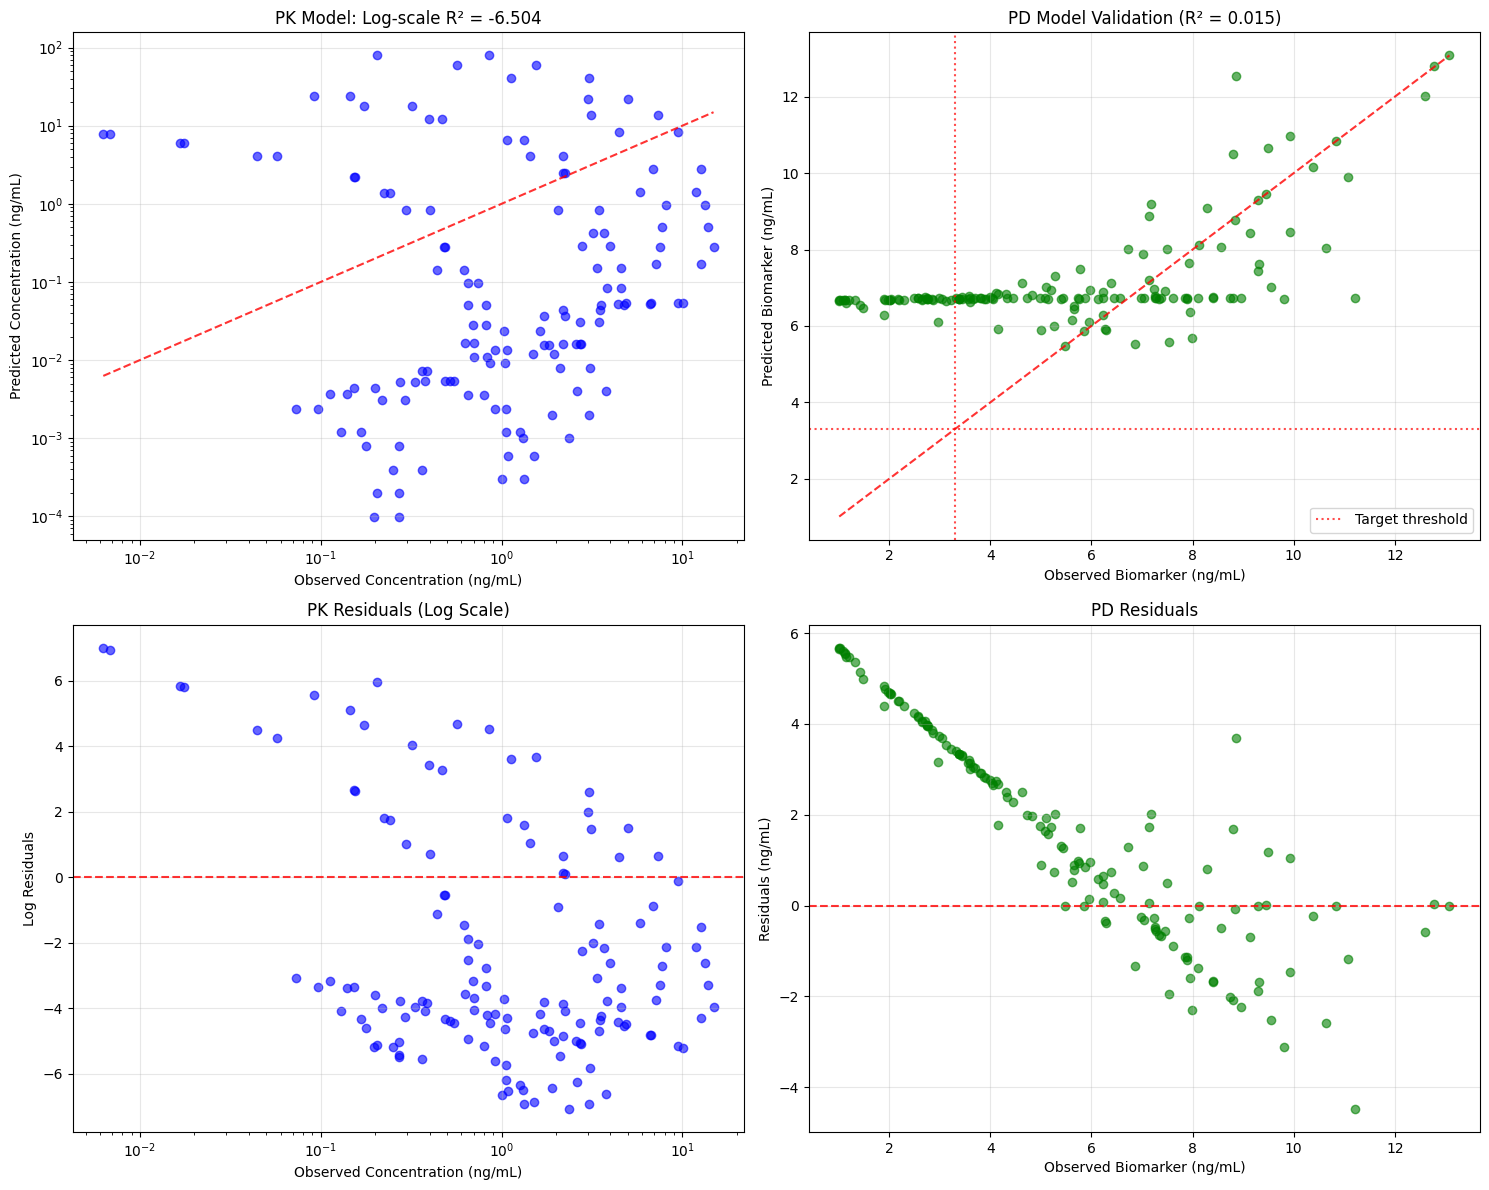

SECTION 5: DOSE OPTIMIZATION - DISCRETE DOSING

Baseline Distribution Analysis:
  Valid baselines: 48 subjects
  Range: 4.97 - 18.62 ng/mL
  Mean: 9.12 ng/mL
  Median: 8.84 ng/mL
  Std: 2.69 ng/mL
Discrete Dose Optimization Setup:
  Target: 90% of population with biomarker < 3.3 ng/mL
  Success criteria: 95% of steady-state time below threshold
  Steady-state: Last 168 hours of simulation
  Method: Discrete dosing (no numerical spikes)

ANSWERING THE 5 QUESTIONS - DISCRETE DOSING METHOD

QUESTION 1: Optimal daily dose (base population, 90% target)

Optimizing 24h discrete dosing...
  Target success rate: 90.0%
  Population size: 500

QUESTION 2: Optimal weekly dose (base population, 90% target)

Optimizing 7d discrete dosing...
  Target success rate: 90.0%
  Population size: 500

QUESTION 3: Extended BW population (70-140 kg, 90% target)

Optimizing 24h discrete dosing...
  Target success rate: 90.0%
  Population size: 500

Optimizing 7d discrete dosing...
  Target success rate: 90.0%


In [44]:

if __name__ == "__main__":
    # Run discrete dosing test first
    test_success = test_discrete_dosing()
    
    if test_success:
        print("\n" + "="*60)
        print("PROCEEDING TO FULL DISCRETE DOSING ANALYSIS")
        print("="*60)
        
        # Run full analysis
        results, trainer, optimizer, pkpd_model, data_processor = main_discrete()
    else:
        print("Discrete dosing test failed - check implementation")

                